In [1]:
import os

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gseapy as gp
from notebooks.tasks58.plots import plot_correlations
from notebooks.tasks58.scaling import median_scaling

import os

while os.getcwd()[-len('mcrc-cetuximab-analysis'):] != 'mcrc-cetuximab-analysis':
    os.chdir('..')
os.getcwd() 

'/home/max/mcrc-cetuximab-analysis'

In [2]:
log_tpms = pd.read_csv('data/log_tpms_from_fpkm_hgnc_filtered_by_ann.csv', index_col=0)
ann = pd.read_csv('data/ann.csv', index_col=0)

## Parse EMT signatures

In [3]:
our_genes = log_tpms.columns 

def parse_emt(file):
    res = []
    full_res = []
    
    if 'emt_bg' in file:
        for gene in open(file, 'r').read().split():
            full_res.append(gene)
            if gene in our_genes:
                res.append(gene)
    else:
        for line in open(file, 'r').readlines():
            if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene'):
                full_res.append(line.split()[0])
            if not line.startswith('(') and not line.startswith('GO') and not line.startswith('Gene') and line.split()[0] in our_genes:
                res.append(line.split()[0])
    
    return full_res, res

emt_raw_files = ['raw/' + file for file in os.listdir('raw') if file.startswith('emt')]
emt_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[1] for file in emt_raw_files}
emt_full_gene_lists = {file[file.find('/') + 1:file.find('.')]: parse_emt(file)[0] for file in emt_raw_files}

for filename, lst in emt_gene_lists.items():
    open(f'data/gene_lists/{filename}.txt', 'w').write(', '.join(lst))
    print(f'Full emt signature {filename} / filtered to our genes', len(emt_full_gene_lists[filename]), ' / ', len(emt_gene_lists[filename]))

print({key: len(emt_gene_lists[key]) for key in emt_gene_lists})

Full emt signature emt_bg / filtered to our genes 7  /  7
Full emt signature emt_pitts / filtered to our genes 9  /  9
Full emt signature emt_budinska / filtered to our genes 33  /  33
Full emt signature emt_joyce / filtered to our genes 82  /  81
Full emt signature emt_moor / filtered to our genes 5  /  5
Full emt signature emt_schell / filtered to our genes 20  /  18
{'emt_bg': 7, 'emt_pitts': 9, 'emt_budinska': 33, 'emt_joyce': 81, 'emt_moor': 5, 'emt_schell': 18}


# Prepare ssGSEA and scale for pre and post separately

In [4]:
log_tpms_with_emt_signatures = log_tpms.copy()

ssgsea_results = gp.ssgsea(data=log_tpms.T,
                           gene_sets=emt_gene_lists,
                           outdir=None,
                           sample_norm_method='rank',
                           permutation_num=0,
                           no_plot=True,
                           min_size=0)

ssgsea_df = ssgsea_results.res2d.rename(columns={'Name': 'sample_id'})

for signature in emt_gene_lists:
    add = ssgsea_df.loc[ssgsea_df['Term'] == signature, ['sample_id', 'ES']]
    log_tpms_with_emt_signatures = log_tpms_with_emt_signatures.merge(add, left_index=True, right_on='sample_id').rename(columns={'ES': signature}).set_index('sample_id').astype({signature: np.float64})

print(log_tpms_with_emt_signatures.isna().sum().max())

log_tpms_with_emt_signatures_with_ann = log_tpms_with_emt_signatures.merge(ann, left_index=True, right_index=True)
log_tpms_with_emt_signatures_with_ann.to_csv('data/unscaled_ssgsea_expr_ann.csv')

df_post = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'post-treatment']
df_pre = log_tpms_with_emt_signatures_with_ann[log_tpms_with_emt_signatures_with_ann['time point'] == 'pre-treatment']

# Scale separetely
for i, signature in enumerate(emt_gene_lists):
    df_pre[signature + '_rank'] = df_pre[signature].rank(ascending=False)
    df_pre[signature + '_med'] = median_scaling(df_pre[signature])
    df_post[signature + '_rank'] = df_post[signature].rank(ascending=False)
    df_post[signature + '_med'] = median_scaling(df_post[signature])

df_pre_pd = df_pre[df_pre['treatment response'] == 'PD']
df_pre_npd = df_pre[df_pre['treatment response'] == 'non-PD']
df_post_pd = df_post[df_post['treatment response'] == 'PD']
df_post_npd = df_post[df_post['treatment response'] == 'non-PD']

0


/tmp/ipykernel_6719/2217504629.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre[signature + '_rank'] = df_pre[signature].rank(ascending=False)
/tmp/ipykernel_6719/2217504629.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pre[signature + '_med'] = median_scaling(df_pre[signature])
/tmp/ipykernel_6719/2217504629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

## Plot correlations

In [5]:
def plot_correlations_gene_with_pathway(gene, pathway_filename):
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    
    plot_correlations(df_pre, f'Pre-treatment correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[0][0])
    plot_correlations(df_post, f'Post-treatment correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[0][1])
    plot_correlations(df_pre_pd, f'Pre-treatment PD correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[1][0])
    plot_correlations(df_post_pd, f'Post-treatment PD correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[1][1])
    plot_correlations(df_pre_npd, f'Pre-treatment non-PD correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[2][0])
    plot_correlations(df_post_npd, f'Post-treatment non-PD correlation {gene} with {pathway_filename} genes', f'{gene}', f'data/gene_lists/{pathway_filename}.txt',
                      xlim=(-1, 1), ax=axs[2][1])

MET genes in total:  16
MET genes in our data:  5
Negative genes:  
Positive genes:  
MET genes in total:  16
MET genes in our data:  5
Negative genes:  SRF
Positive genes:  NRAS
MET genes in total:  16
MET genes in our data:  5
Negative genes:  
Positive genes:  
MET genes in total:  16
MET genes in our data:  5
Negative genes:  
Positive genes:  
MET genes in total:  16
MET genes in our data:  5
Negative genes:  
Positive genes:  
MET genes in total:  16
MET genes in our data:  5
Negative genes:  SRF
Positive genes:  NRAS


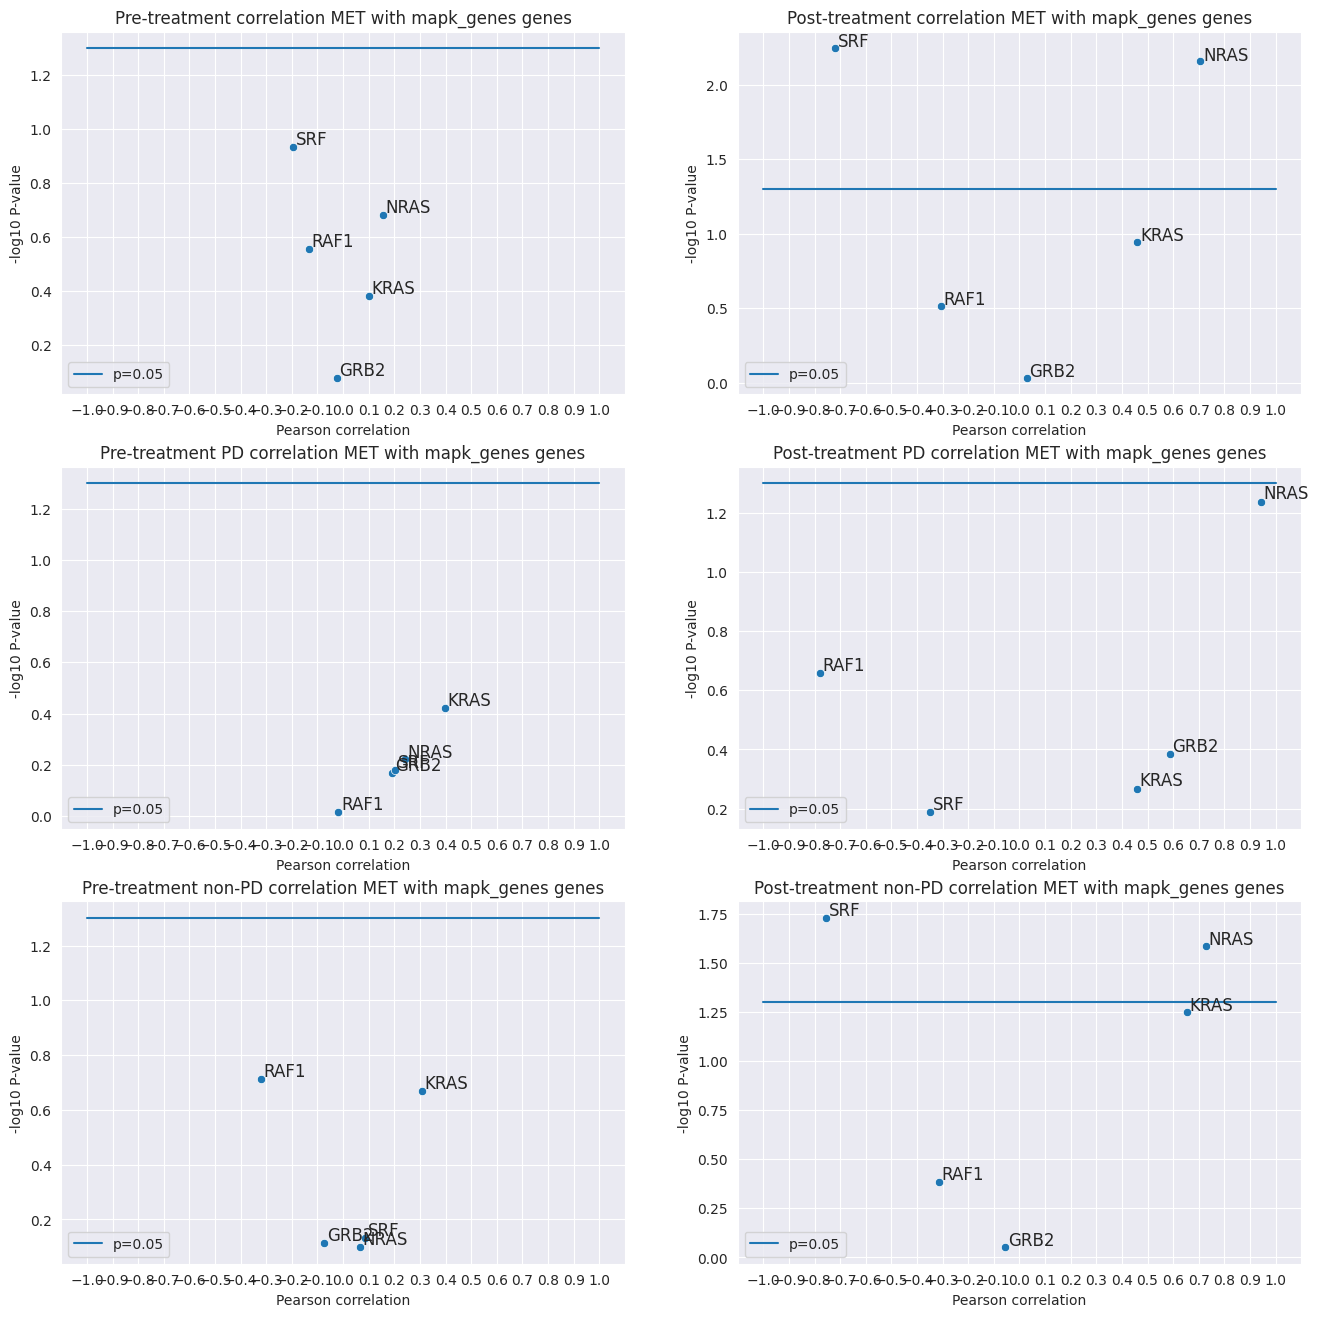

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [6]:
plot_correlations_gene_with_pathway('MET', 'mapk_genes')

MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, PIK3CG, PIK3R3, TSC1, TSC2, BAD, RELA, BCL2, CASP9, VEGFB, NRP1, ANGPT1, TEK, HGF, IL6R, IL6ST, JAK1, STAT5A
Positive genes:  RHEB, GSK3B, CHUK, CCNE1, E2F1, E2F3, EIF4E, MET


/home/max/mcrc-cetuximab-analysis/notebooks/tasks58_maxim/plots.py:14: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, PIK3CG, AKT2, AKT3, TSC1, TSC2, FOXO1, IRS1, BCL2, CASP9, KDR, NRP2, ANGPT1, TEK, HGF, IL6ST, JAK1, JAK2, STAT3, STAT5B
Positive genes:  RHEB, NRAS, BAX, CDK2, EIF4E, VEGFA, TGFA, MET
MET genes in total:  86
MET genes in our data:  81
Negative genes:  HRAS, RELA, VEGFB, EGFR
Positive genes:  PDPK1, IRS2, NFKB1, CHUK, MET


/home/max/mcrc-cetuximab-analysis/notebooks/tasks58_maxim/plots.py:14: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


MET genes in total:  86
MET genes in our data:  81
Negative genes:  INSR, HGF
Positive genes:  RHEB, IRS2, MAPK3, MET


/home/max/mcrc-cetuximab-analysis/notebooks/tasks58_maxim/plots.py:14: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])
/home/max/mcrc-cetuximab-analysis/notebooks/tasks58_maxim/plots.py:14: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


MET genes in total:  86
MET genes in our data:  81
Negative genes:  MDM2, CDKN1B
Positive genes:  RHEB, MET
MET genes in total:  86
MET genes in our data:  81
Negative genes:  PIK3CD, PIK3CG, AKT3, TSC1, FOXO1, IRS1, CASP9, HIF1A, VEGFB, NRP1, NRP2, ANGPT1, TEK, HGF, IL6ST, STAT3, STAT5A, STAT5B
Positive genes:  PIK3R2, RHEB, HRAS, NRAS, BAX, CCNE1, CDK2, EIF4E, TGFA, MET


/home/max/mcrc-cetuximab-analysis/notebooks/tasks58_maxim/plots.py:14: RuntimeWarning: divide by zero encountered in log10
  neg_log_ps = np.array([-np.log10(p) for p in ps])


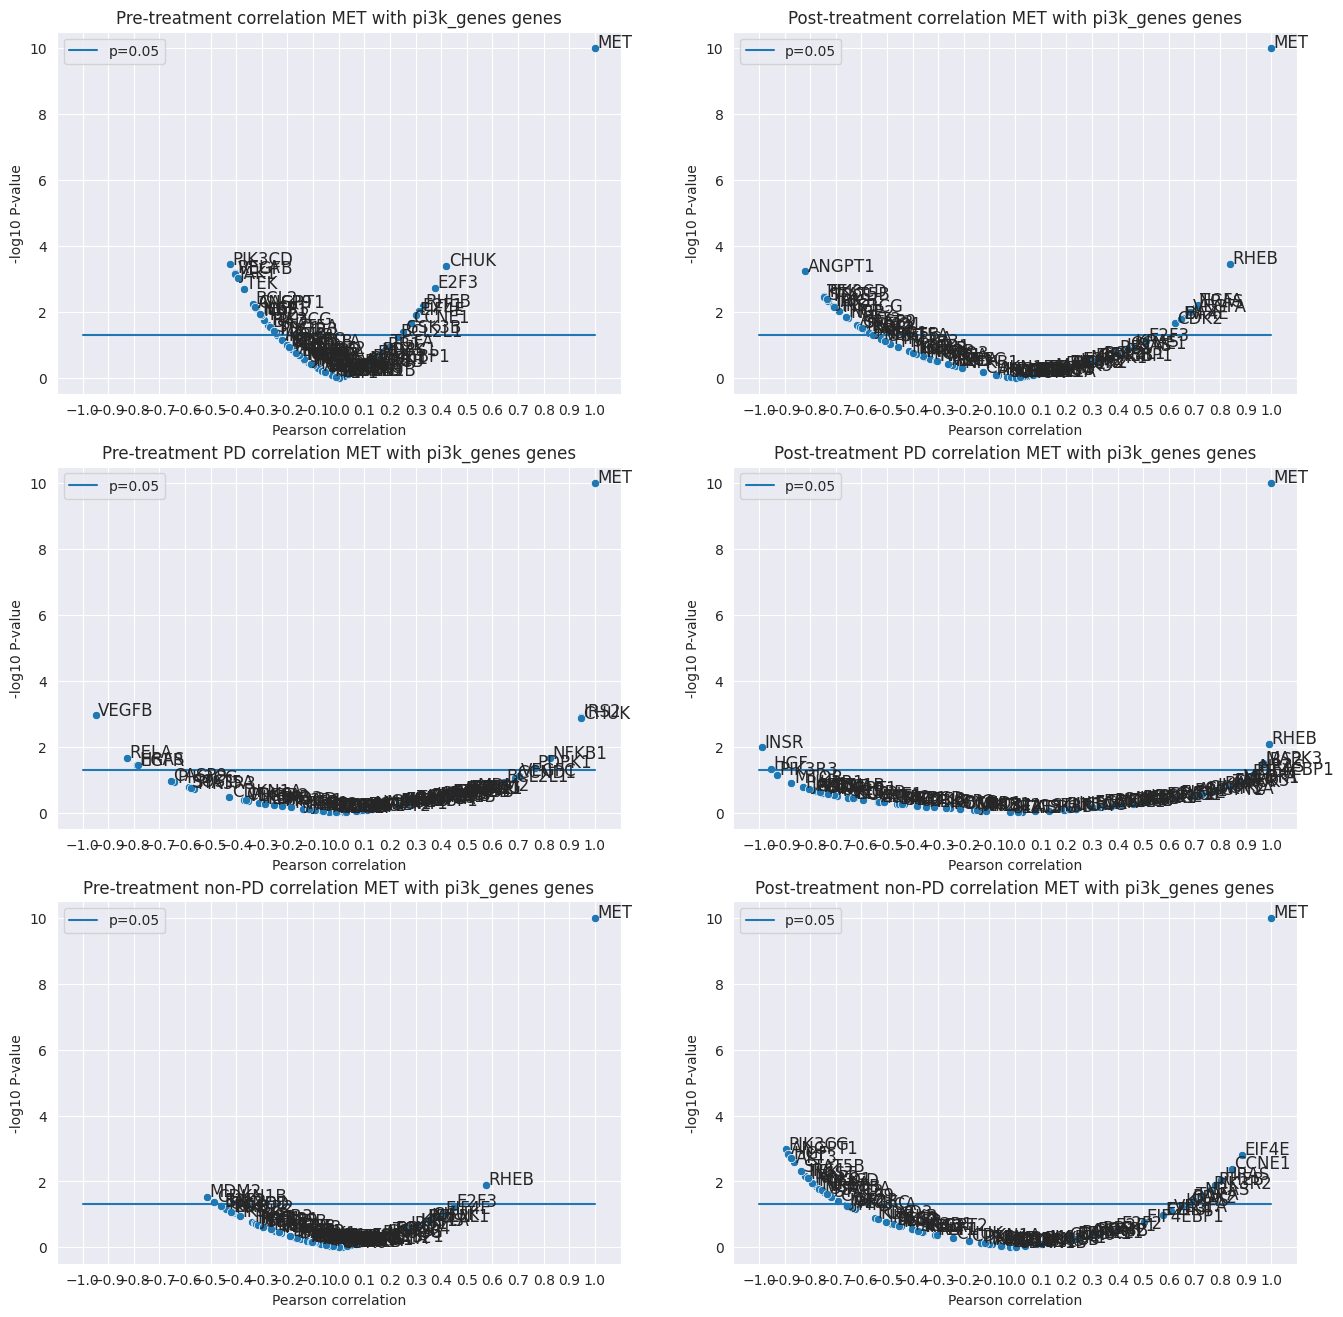

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [7]:
plot_correlations_gene_with_pathway('MET', 'pi3k_genes')

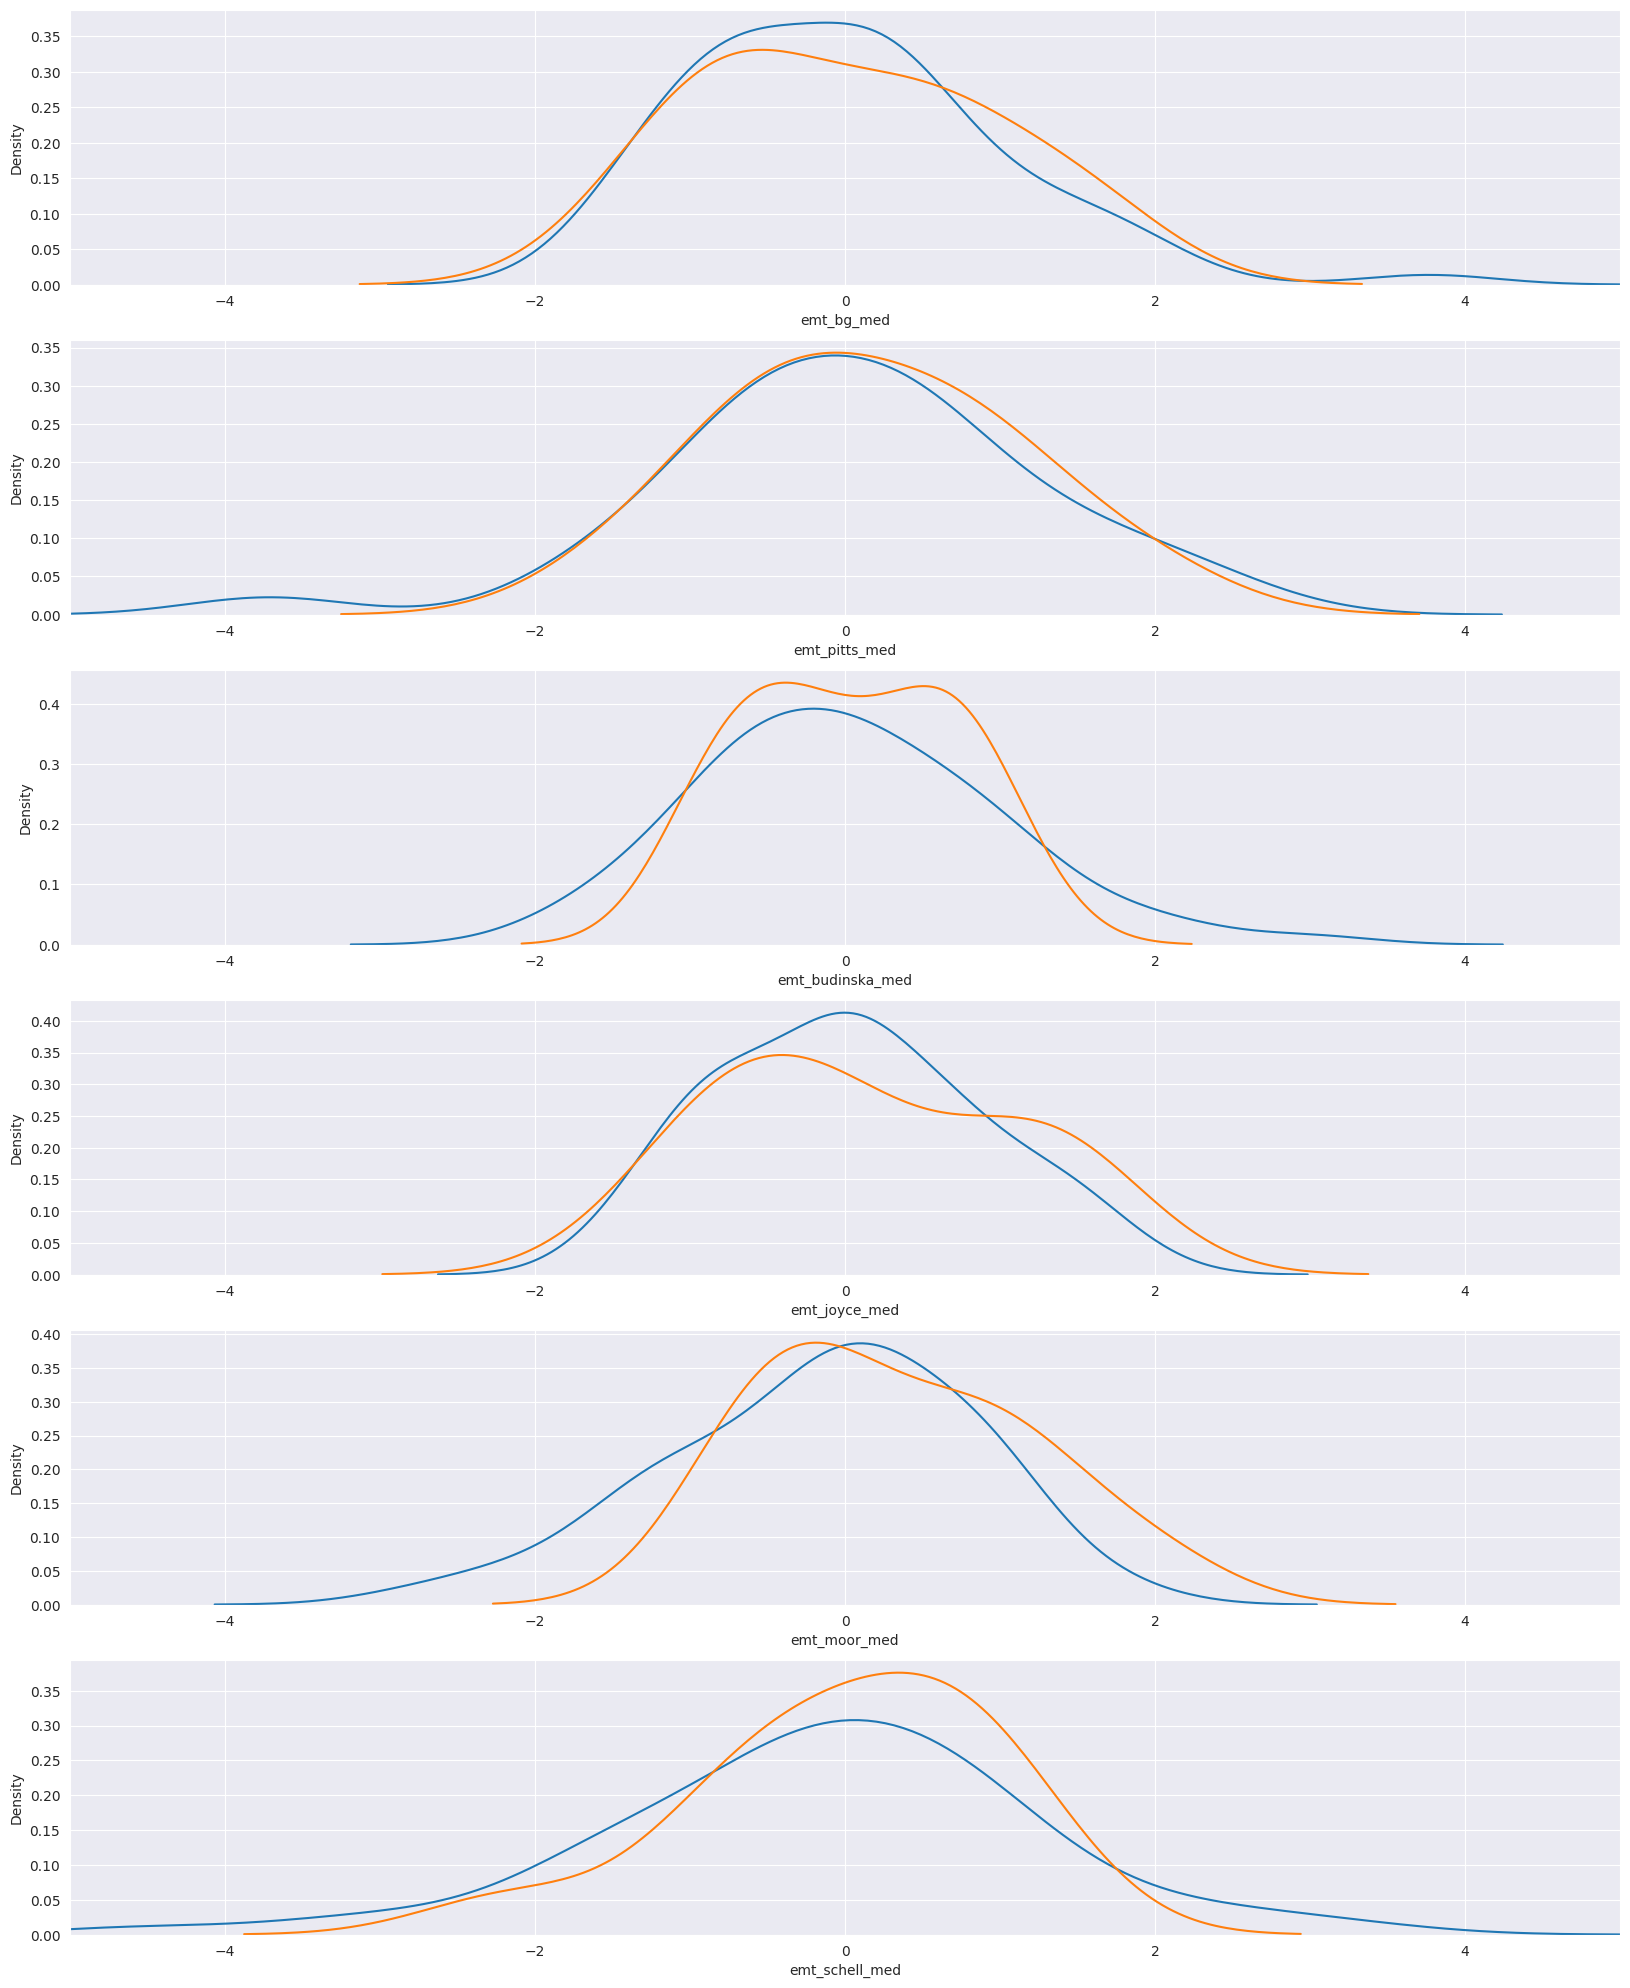

In [8]:
fig, axs = plt.subplots(len(emt_gene_lists), 1, figsize=(20, 25))
for i, signature in enumerate(emt_gene_lists):
    # sns.histplot(log_tpms_with_emt_signatures[signature], bins=30, ax=axs[i])
    axs[i].set_xlim(-5, 5)
    sns.kdeplot(df_pre[signature + '_med'], ax=axs[i], label='pre')
    sns.kdeplot(df_post[signature + '_med'], ax=axs[i], label='post')

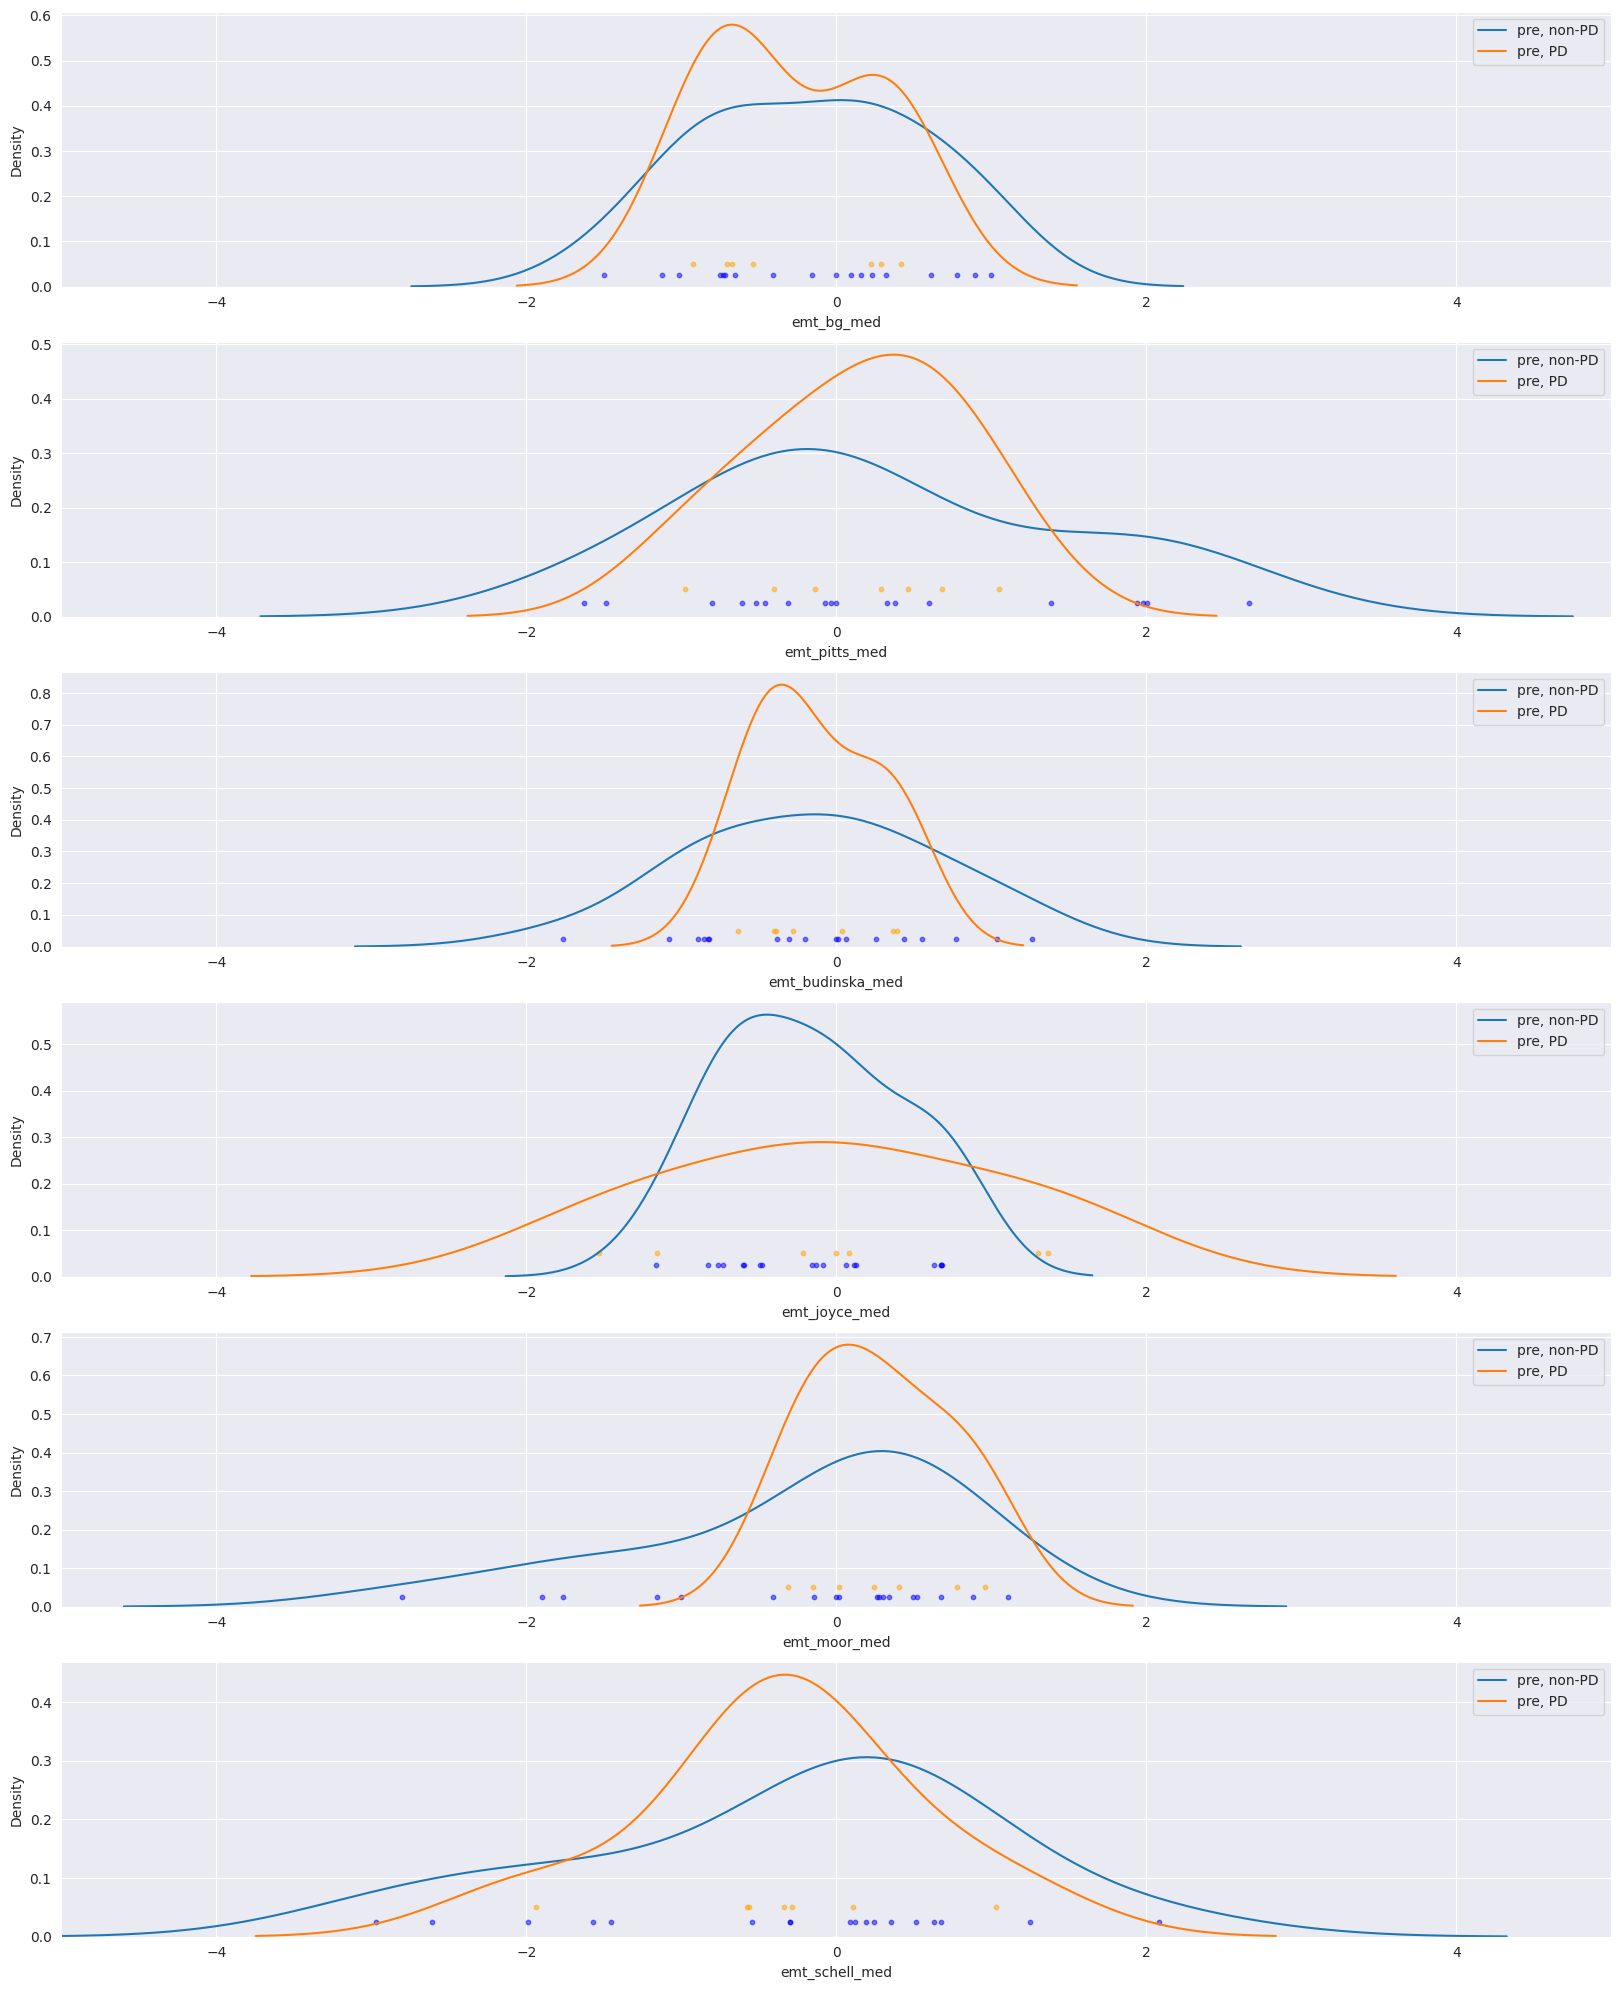

In [9]:
fig, axs = plt.subplots(len(emt_gene_lists), 1, figsize=(20, 25))
for i, signature in enumerate(emt_gene_lists):
    # sns.histplot(log_tpms_with_emt_signatures[signature], bins=30, ax=axs[i])
    axs[i].set_xlim(-5, 5)
    d1 = df_pre[df_pre['treatment response'] == 'non-PD'][signature + '_med']
    d2 = df_pre[df_pre['treatment response'] == 'PD'][signature + '_med']
    sns.kdeplot(d1, ax=axs[i], label='pre, non-PD')
    # sns.stripplot(d1, ax=axs[i], orient='h', label='pre, non-PD')
    axs[i].scatter(d1, [0.025]*len(d1), color='blue', alpha=0.5, s=10)
    sns.kdeplot(d2, ax=axs[i], label='pre, PD')
    axs[i].scatter(d2, [0.05]*len(d2), color='orange', alpha=0.5, s=10)
    # sns.stripplot(d2, ax=axs[i], orient='h', label='pre, PD') 
    axs[i].legend()

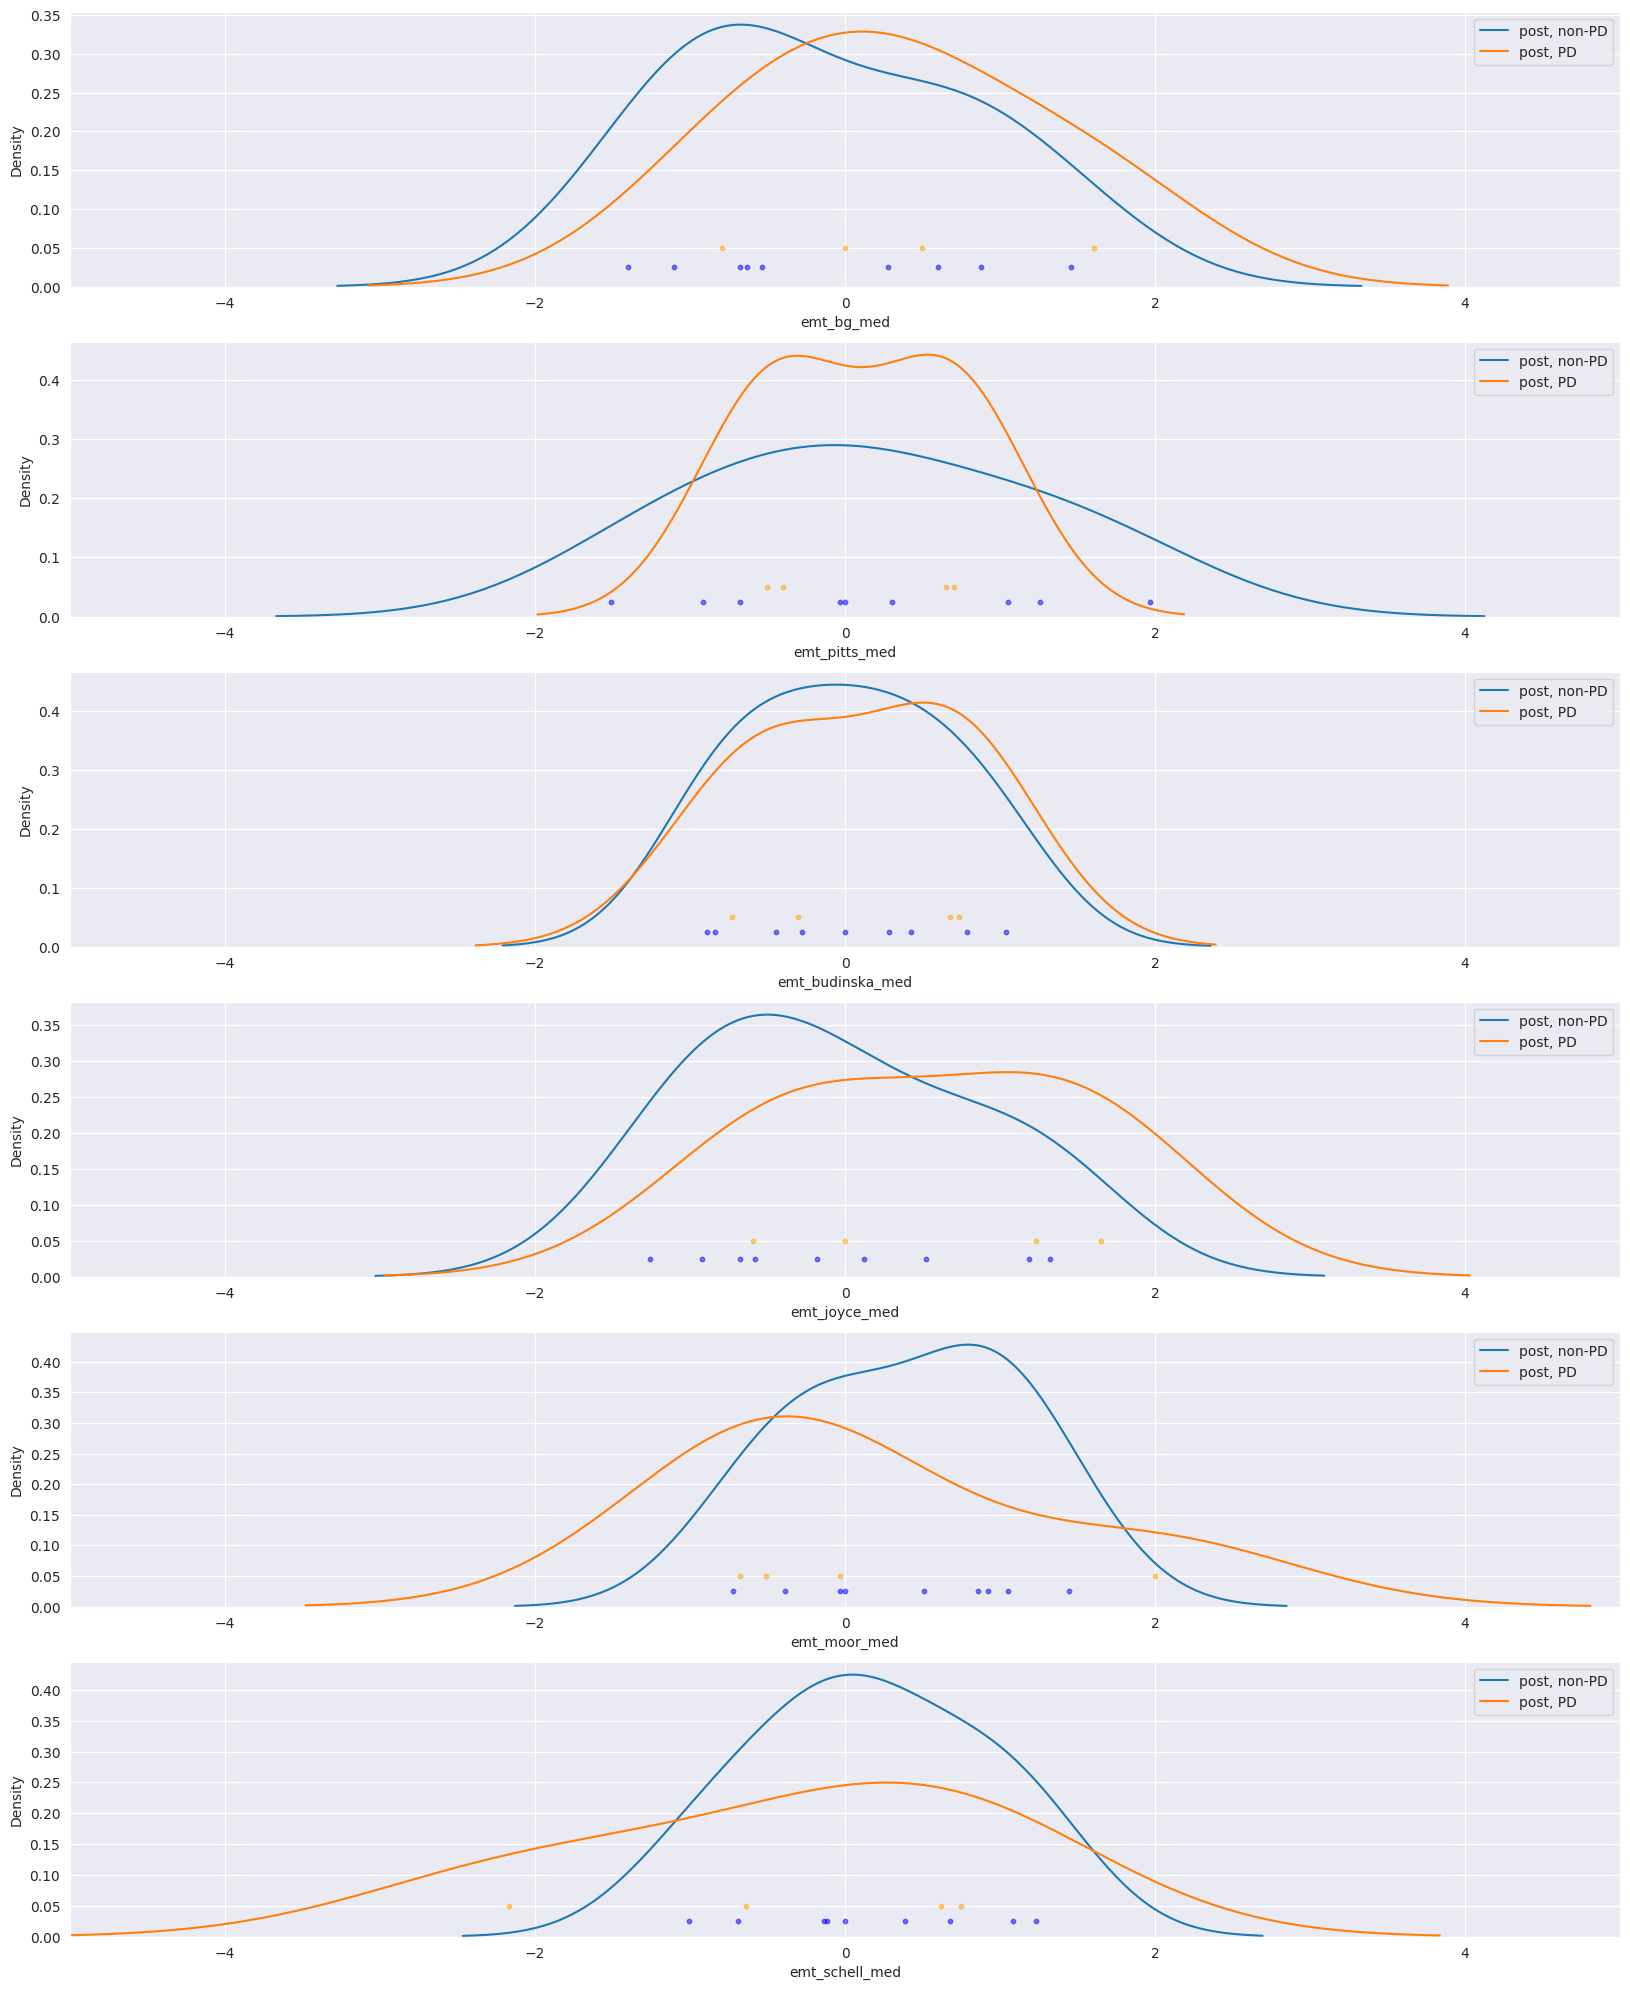

In [10]:
fig, axs = plt.subplots(len(emt_gene_lists), 1, figsize=(20, 25))
for i, signature in enumerate(emt_gene_lists):
    # sns.histplot(log_tpms_with_emt_signatures[signature], bins=30, ax=axs[i])
    axs[i].set_xlim(-5, 5)
    d1 = df_post[df_post['treatment response'] == 'non-PD'][signature + '_med']
    d2 = df_post[df_post['treatment response'] == 'PD'][signature + '_med']
    sns.kdeplot(d1, ax=axs[i], label='post, non-PD')
    axs[i].scatter(d1, [0.025]*len(d1), color='blue', alpha=0.5, s=10)
    
    sns.kdeplot(d2, ax=axs[i], label='post, PD')
    axs[i].scatter(d2, [0.05]*len(d2), color='orange', alpha=0.5, s=10)
    
    axs[i].legend()

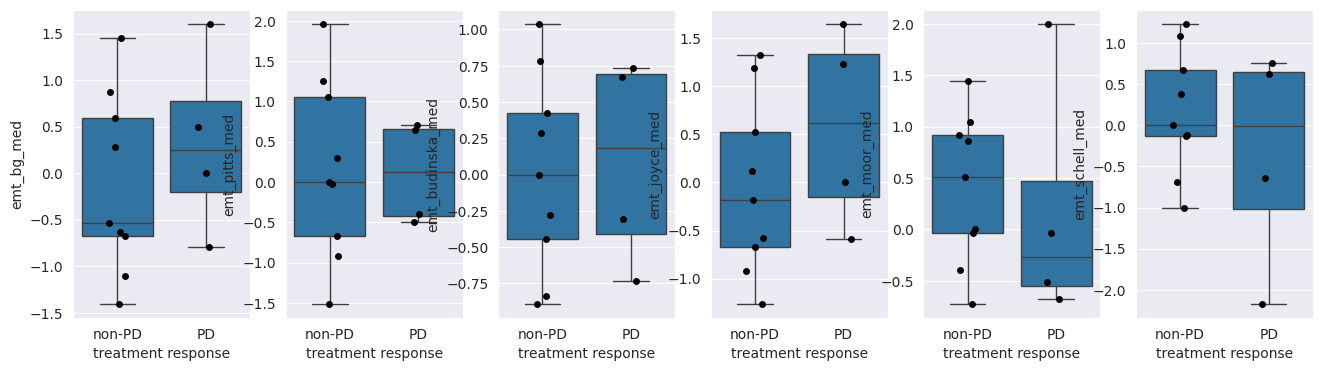

In [11]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_post, x='treatment response', y=f'{signature}_med', ax=ax)
    sns.stripplot(x='treatment response', y=f'{signature}_med', data=df_post, color='black', jitter=True, dodge=True, ax=ax)

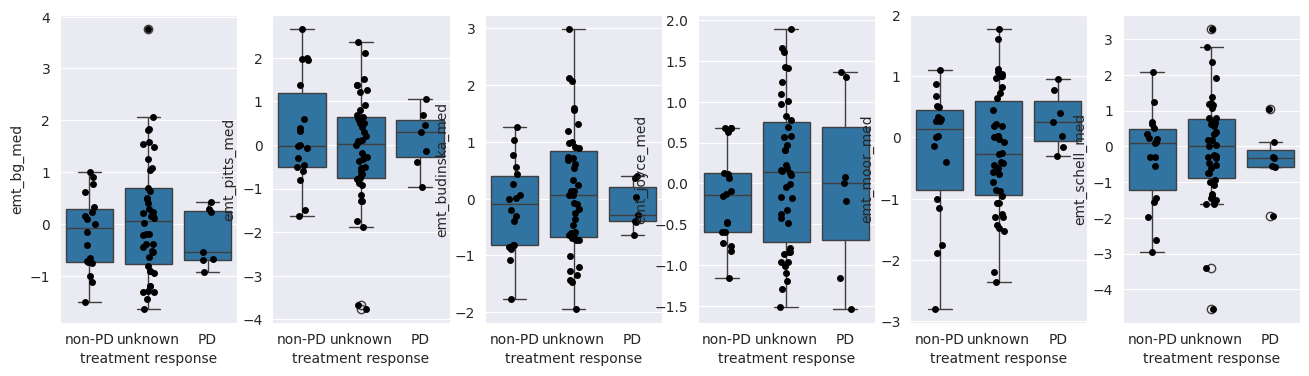

In [12]:
fig, axs = plt.subplots(1, len(emt_gene_lists), figsize=(16, 4))

for signature, ax in zip(emt_gene_lists, axs):
    sns.boxplot(df_pre, x='treatment response', y=f'{signature}_med', ax=ax)
    sns.stripplot(x='treatment response', y=f'{signature}_med', data=df_pre, color='black', jitter=True, dodge=True, ax=ax)

MET genes in total:  6
MET genes in our data:  6
Negative genes:  emt_bg_med, emt_budinska_med
Positive genes:  
MET genes in total:  6
MET genes in our data:  6
Negative genes:  emt_budinska_med
Positive genes:  
MET genes in total:  6
MET genes in our data:  6
Negative genes:  
Positive genes:  
MET genes in total:  6
MET genes in our data:  6
Negative genes:  
Positive genes:  
MET genes in total:  6
MET genes in our data:  6
Negative genes:  
Positive genes:  
MET genes in total:  6
MET genes in our data:  6
Negative genes:  emt_bg_med, emt_budinska_med, emt_joyce_med
Positive genes:  


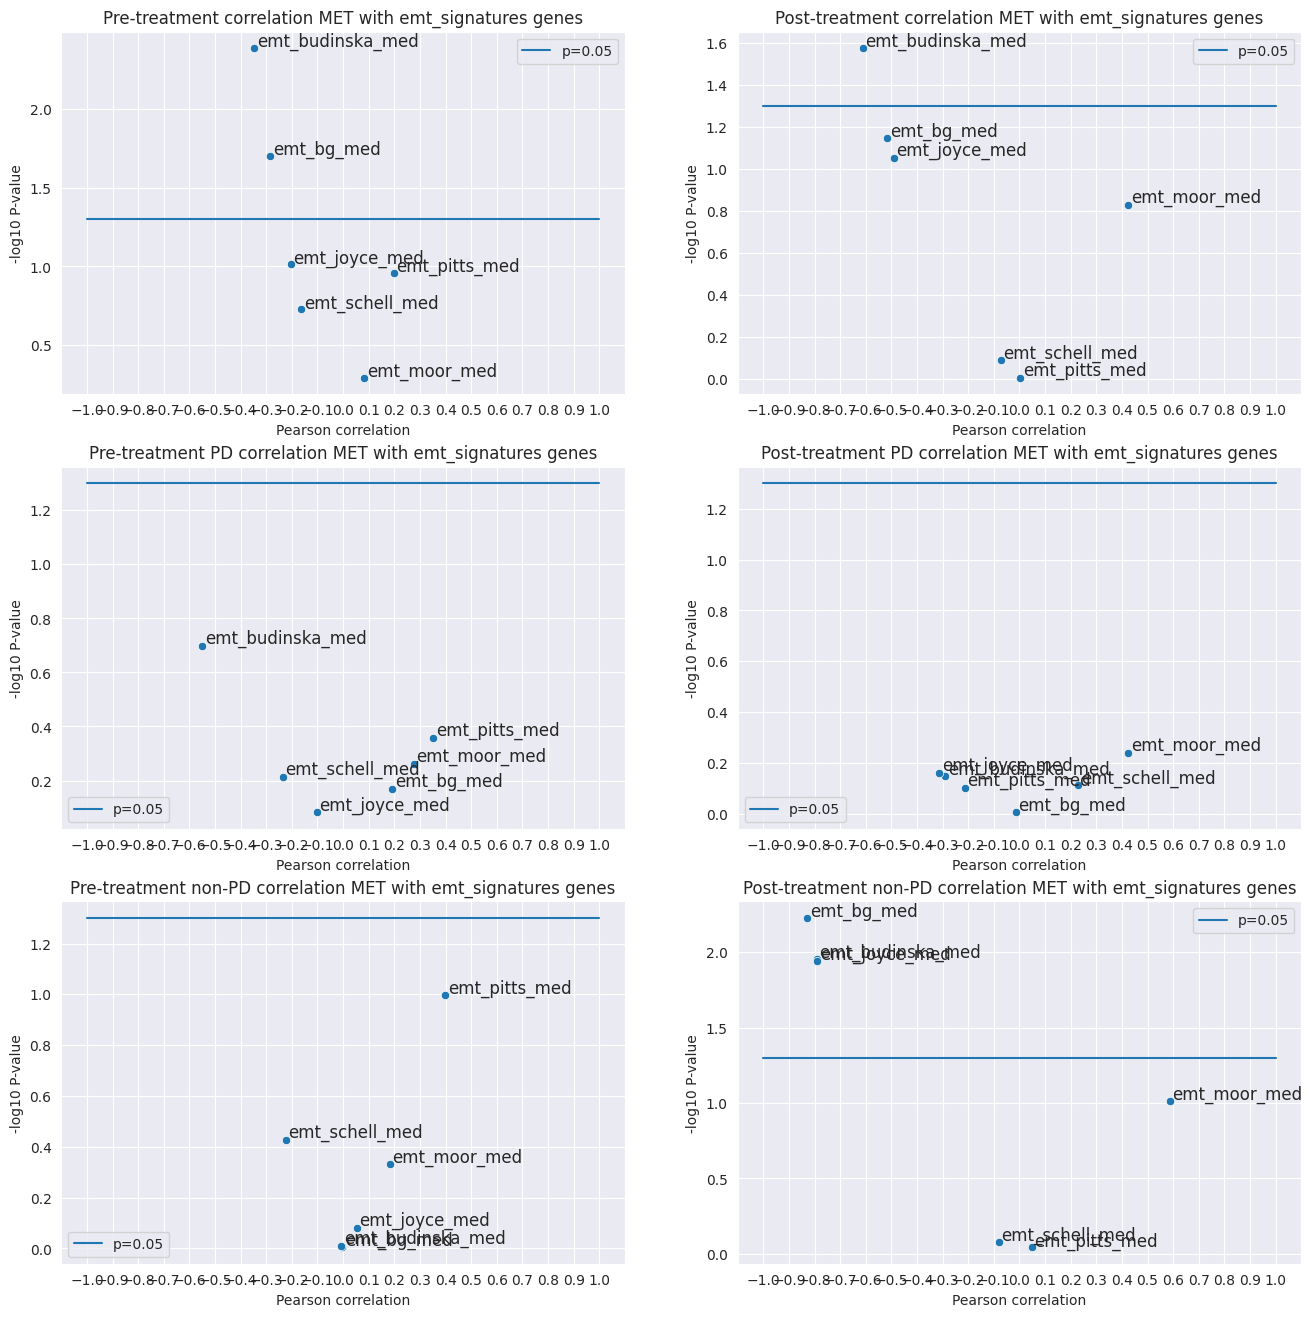

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

In [13]:
signatures_file = open('data/gene_lists/emt_signatures.txt', 'w').write('emt_bg_med, emt_pitts_med, emt_budinska_med, emt_joyce_med, emt_moor_med, emt_schell_med')

plot_correlations_gene_with_pathway('MET', 'emt_signatures')

Text(0.5, 1.0, 'post-treatment non-pd samples')

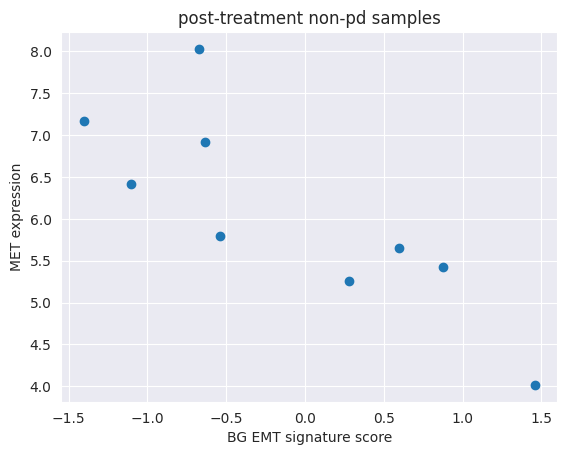

In [14]:
plt.scatter(df_post_npd['emt_bg_med'], df_post_npd['MET'])
plt.xlabel('BG EMT signature score')
plt.ylabel('MET expression')
plt.title('post-treatment non-pd samples')

In [15]:
raw_counts = pd.read_csv('data/raw_counts_hgnc_filtered_by_ann.csv', index_col=0)
raw_counts.sum(axis=1).describe()

count    8.000000e+01
mean     4.047621e+07
std      7.351806e+06
min      9.085718e+06
25%      3.675862e+07
50%      4.052260e+07
75%      4.420089e+07
max      5.955719e+07
dtype: float64

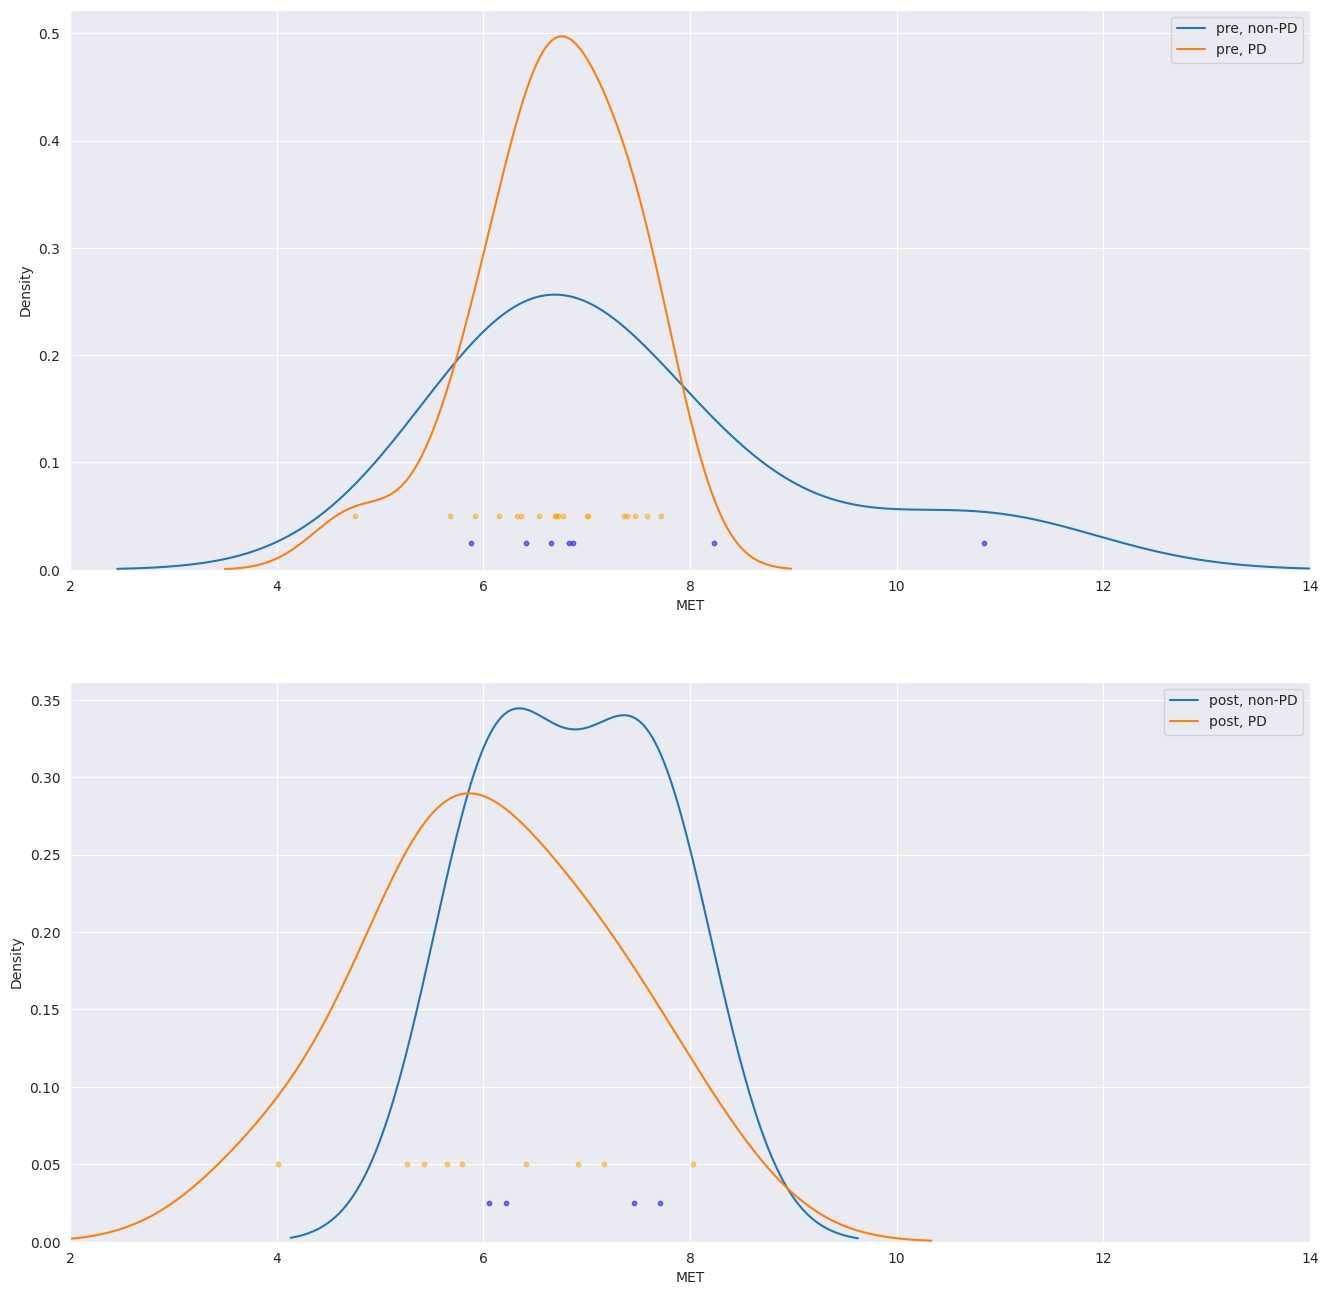

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 16))


d1 = df_pre_pd['MET']
d2 = df_pre_npd['MET']
sns.kdeplot(d1, ax=axs[0], label='pre, non-PD')
axs[0].scatter(d1, [0.025]*len(d1), color='blue', alpha=0.5, s=10)
sns.kdeplot(d2, ax=axs[0], label='pre, PD')
axs[0].scatter(d2, [0.05]*len(d2), color='orange', alpha=0.5, s=10)
axs[0].set_xlim(2, 14)
axs[0].legend()

d1 = df_post_pd['MET']
d2 = df_post_npd['MET']
sns.kdeplot(d1, ax=axs[1], label='post, non-PD')
axs[1].scatter(d1, [0.025]*len(d1), color='blue', alpha=0.5, s=10)
sns.kdeplot(d2, ax=axs[1], label='post, PD')
axs[1].scatter(d2, [0.05]*len(d2), color='orange', alpha=0.5, s=10)
axs[1].set_xlim(2, 14)
axs[1].legend()

## TODO:
1. Pearson correlation plot label, pvalue, CI (like Dima's picture)
2. Give list of correlating gene to Elza and see them on volcanoplot
3. Investigate genes that correlate and volcano.
4. 